### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Find the number of sequences

In [2]:
'''
import pathlib
vir_path = pathlib.Path('./sequences/edwards/virus/')
host_path = pathlib.Path('./sequences/edwards/host/')
vir_count = 0
host_count = 0
for vir_file in vir_path.iterdir():
    vir_count += 1
for host_file in host_path.iterdir():
    host_count += 1

print(f'virus files: {vir_count}')
print(f'host files: {host_count}')
print(f'paired files: {vir_count * host_count}')
'''

"\nimport pathlib\nvir_path = pathlib.Path('./sequences/edwards/virus/')\nhost_path = pathlib.Path('./sequences/edwards/host/')\nvir_count = 0\nhost_count = 0\nfor vir_file in vir_path.iterdir():\n    vir_count += 1\nfor host_file in host_path.iterdir():\n    host_count += 1\n\nprint(f'virus files: {vir_count}')\nprint(f'host files: {host_count}')\nprint(f'paired files: {vir_count * host_count}')\n"

## Importing the dataset

### Merge the datasets

In [3]:
import pathlib
from functools import reduce

features_path = pathlib.Path('./features/')
dfs = [pd.read_csv(feat_file, sep='\t', header=0) 
                    for feat_file in features_path.iterdir()]
final_df = reduce(lambda left,right: 
                pd.merge(left,right,
                on=["#virus", "bacteria"],how="outer"), dfs)
final_df.shape

(2213180, 11)

## Replace the column names

In [4]:
col_names = ['virus', 'host']
col_names += [file.stem for file in features_path.iterdir()]
final_df.columns = col_names
final_df.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish
0,NC_010363,NC_008527,60.8,NaN,0.021973,NaN,0.002122,0.398421,0.382144,NaN,-1.33553
1,NC_010363,NC_002662,59.0,NaN,0.016709,NaN,0.001929,0.397773,0.377498,NaN,-1.33035
2,NC_010363,NC_017949,59.0,NaN,0.020818,NaN,0.002088,0.396969,0.379686,NaN,-1.33341
3,NC_010363,NC_017492,59.0,NaN,0.022209,NaN,0.002131,0.396148,0.380930,NaN,-1.33767
4,NC_010363,NC_009004,59.0,NaN,0.020871,NaN,0.002088,0.397095,0.379834,NaN,-1.33341


## Handle missing values

### Check for missing values

In [5]:
check_rows = final_df[~final_df.isnull().any(axis=1)]
check_rows.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish
3611,NC_011357,NC_012731,670.0,1.0,0.067620,2.0,0.002660,0.468791,0.410775,1.0,-1.38249
4182,NC_004585,NC_008022,22561.0,2.0,0.001751,14364.0,0.000713,0.285006,0.232619,1.0,-1.33040
4183,NC_004585,NC_008021,22561.0,2.0,0.002832,10850.0,0.000736,0.288697,0.235694,2.0,-1.33668
4187,NC_004585,NC_002737,12311.0,2.0,0.002570,6765.0,0.000741,0.290344,0.237060,2.0,-1.34749
4190,NC_004585,NC_020540,4621.0,3.0,0.002453,5271.0,0.000749,0.290872,0.237612,1.0,-1.36364


In [6]:
check_rows.shape

(469, 11)

### Check number of missing values

In [7]:
final_df.isna().sum()

virus                           0
host                            0
blastn                    1925573
crisprdetect-2mismatch    2212430
gc_content                      0
k25                       2154290
k6-chebyshev                    0
k6-kendalltau                   0
k6-manhattan                    0
piler-2mismatch           2212592
wish                            0
dtype: int64

In [8]:
final_df.notnull().sum()

virus                     2213180
host                      2213180
blastn                     287607
crisprdetect-2mismatch        750
gc_content                2213180
k25                         58890
k6-chebyshev              2213180
k6-kendalltau             2213180
k6-manhattan              2213180
piler-2mismatch               588
wish                      2213180
dtype: int64

### Fill missing values (according to promoter's suggestions)

In [9]:
final_df['blastn'].fillna(0, inplace=True)
final_df['crisprdetect-2mismatch'].fillna(0, inplace=True)
final_df['k25'].fillna(0, inplace=True)
final_df['piler-2mismatch'].fillna(0, inplace=True)

In [10]:
final_df.isna().sum()

virus                     0
host                      0
blastn                    0
crisprdetect-2mismatch    0
gc_content                0
k25                       0
k6-chebyshev              0
k6-kendalltau             0
k6-manhattan              0
piler-2mismatch           0
wish                      0
dtype: int64

## Find labels (which viruses infect which hosts in nature)

### Load in the taxonomy JSONs

In [11]:
import json
import pathlib

orgs = {}
for file in pathlib.Path('./taxonomy/').iterdir():
    with open(file, 'r') as open_file:
        orgs[file.stem] = json.load(open_file)
        
orgs.keys()

dict_keys(['host', 'virus'])

### Find groups for LeaveOneGroupOut

In [12]:
final_df['group'] = final_df.apply(lambda row: 
                    orgs['virus'][row['virus']]['host']['lineage_names'][-3], axis=1)

In [13]:
pd.unique(final_df['group'])

array(['Streptococcaceae', 'Xanthomonadaceae', 'Enterobacteriaceae',
       'Aeromonadaceae', 'Staphylococcaceae', 'Nocardiaceae',
       'Streptomycetaceae', 'Rhodobacteraceae', 'Burkholderiaceae',
       'Enterococcaceae', 'Pseudomonadaceae', 'Bacillaceae',
       'Leuconostocaceae', 'Moraxellaceae', 'Vibrionaceae',
       'Listeriaceae', 'Lactobacillaceae', 'Campylobacteraceae',
       'Propionibacteriaceae', 'Mycobacteriaceae', 'Chlamydiaceae',
       'Clostridiaceae', 'Shewanellaceae', 'Prochlorococcaceae',
       'Pasteurellaceae', 'Bacteroidaceae',
       'Thermoanaerobacterales Family III. Incertae Sedis',
       'Helicobacteraceae', 'Brucellaceae', 'Peptostreptococcaceae',
       'Microbacteriaceae', 'Acholeplasmataceae', 'Flavobacteriaceae',
       'Rhizobiaceae', 'Mycoplasmataceae', 'Caulobacteraceae',
       'Thermaceae', 'Alcaligenaceae', 'Bdellovibrionaceae',
       'Rhodospirillaceae', 'Rhodothermaceae', 'Comamonadaceae', '',
       'Corynebacteriaceae', 'Alteromonadacea

In [14]:
final_df['group'].value_counts()

Enterobacteriaceae                                   569489
Pseudomonadaceae                                     251007
Staphylococcaceae                                    199726
Streptococcaceae                                     188930
Bacillaceae                                          140348
Burkholderiaceae                                     113358
Vibrionaceae                                          94465
Mycobacteriaceae                                      59378
Propionibacteriaceae                                  59378
Xanthomonadaceae                                      48582
Lactobacillaceae                                      43184
Listeriaceae                                          43184
Clostridiaceae                                        35087
Enterococcaceae                                       35087
Aeromonadaceae                                        32388
Nocardiaceae                                          26990
Moraxellaceae                           

In [15]:
len(pd.unique(final_df['group']))

48

In [16]:
final_df.head()

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group
0,NC_010363,NC_008527,60.8,0.0,0.021973,0.0,0.002122,0.398421,0.382144,0.0,-1.33553,Streptococcaceae
1,NC_010363,NC_002662,59.0,0.0,0.016709,0.0,0.001929,0.397773,0.377498,0.0,-1.33035,Streptococcaceae
2,NC_010363,NC_017949,59.0,0.0,0.020818,0.0,0.002088,0.396969,0.379686,0.0,-1.33341,Streptococcaceae
3,NC_010363,NC_017492,59.0,0.0,0.022209,0.0,0.002131,0.396148,0.380930,0.0,-1.33767,Streptococcaceae
4,NC_010363,NC_009004,59.0,0.0,0.020871,0.0,0.002088,0.397095,0.379834,0.0,-1.33341,Streptococcaceae


<AxesSubplot:ylabel='group'>

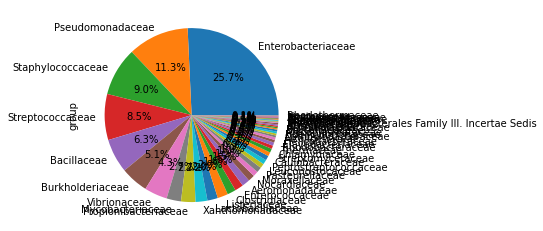

In [17]:
final_df['group'].value_counts().plot(kind="pie", autopct="%1.1f%%")

### Make 'group' parameter categorical – optimilization

In [18]:
final_df['group'].dtype

dtype('O')

In [19]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2213180 entries, 0 to 2213179
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   virus                   object 
 1   host                    object 
 2   blastn                  float64
 3   crisprdetect-2mismatch  float64
 4   gc_content              float64
 5   k25                     float64
 6   k6-chebyshev            float64
 7   k6-kendalltau           float64
 8   k6-manhattan            float64
 9   piler-2mismatch         float64
 10  wish                    float64
 11  group                   object 
dtypes: float64(9), object(3)
memory usage: 219.5+ MB


In [20]:
final_df['group'] = pd.Categorical(final_df['group'])
final_df['group'].dtype

CategoricalDtype(categories=['', 'Acholeplasmataceae', 'Aeromonadaceae', 'Alcaligenaceae',
                  'Alteromonadaceae', 'Bacillaceae', 'Bacteroidaceae',
                  'Bdellovibrionaceae', 'Brucellaceae', 'Burkholderiaceae',
                  'Campylobacteraceae', 'Caulobacteraceae', 'Chlamydiaceae',
                  'Clostridiaceae', 'Comamonadaceae', 'Corynebacteriaceae',
                  'Enterobacteriaceae', 'Enterococcaceae', 'Flavobacteriaceae',
                  'Helicobacteraceae', 'Lactobacillaceae', 'Leuconostocaceae',
                  'Listeriaceae', 'Microbacteriaceae', 'Moraxellaceae',
                  'Mycobacteriaceae', 'Mycoplasmataceae', 'Myxococcaceae',
                  'Nocardiaceae', 'Nostocaceae', 'Pasteurellaceae',
                  'Peptostreptococcaceae', 'Prochlorococcaceae',
                  'Propionibacteriaceae', 'Pseudomonadaceae', 'Rhizobiaceae',
                  'Rhodobacteraceae', 'Rhodospirillaceae', 'Rhodothermaceae',
              

NOTE: what to do with this?

In [24]:
final_df[final_df['group'] == '']

,virus,host,blastn,crisprdetect-2mismatch,gc_content,k25,k6-chebyshev,k6-kendalltau,k6-manhattan,piler-2mismatch,wish,group,y
189108,NC_008562,NC_011729,1936.0,0.0,0.073441,50.0,0.003370,0.851879,0.639265,0.0,-1.43287,,0
189109,NC_008562,NC_010296,1930.0,0.0,0.036224,1431.0,0.002731,0.891840,0.601082,0.0,-1.44261,,1
189110,NC_008562,NC_016640,1159.0,0.0,0.023027,50.0,0.002908,0.864091,0.557508,0.0,-1.44114,,0
189111,NC_008562,NC_019753,801.0,0.0,0.057910,2.0,0.002481,0.797970,0.577121,0.0,-1.42135,,0
189112,NC_008562,NC_014501,720.0,0.0,0.057305,6.0,0.003333,0.830270,0.592474,0.0,-1.42505,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
905267,NC_008562,NC_018417,0.0,0.0,0.314027,0.0,0.048148,0.767260,1.275939,0.0,-1.39383,,0
905268,NC_008562,NC_018415,0.0,0.0,0.317681,0.0,0.053895,0.757731,1.293647,0.0,-1.39432,,0
905269,NC_008562,NC_018416,0.0,0.0,0.317754,0.0,0.050627,0.765630,1.289442,0.0,-1.39417,,0
905270,NC_008562,NC_018414,0.0,0.0,0.319773,0.0,0.050478,0.763087,1.298034,0.0,-1.39409,,0


### Species-based labels

In [22]:
final_df['y'] = final_df.apply(lambda row: 
                    1 if orgs['host'][row['host']]['lineage_names'][-1] == 
                    orgs['virus'][row['virus']]['host']['lineage_names'][-1] 
                    else 0, axis=1)

In [25]:
final_df['y'].value_counts()

0    2196423
1      16757
Name: y, dtype: int64

## Save the dataframe to files

In [26]:
final_df.to_csv('main_df.csv',index=False)
final_df.to_pickle('./main_df.pkl')